# Preprocessing steps analysis for Stanford datasets

### Import modules and define methods

In [1]:
%reload_ext autoreload
%autoreload 2

from preprocess import *
from argparse import Namespace

import matplotlib.pyplot as plt
import subtle.subtle_preprocess as supre
plt.set_cmap('gray')

metadata={}

def show_img(img, title='', axis=False, vmin=None, vmax=None):
    imshow_args = {}
    
    if vmin:
        imshow_args['vmin'] = vmin
    if vmax:
        imshow_args['vmax'] = vmax
    
    im_axis = 'on' if axis else 'off'
    plt.axis(im_axis)
    plt.imshow(img, **imshow_args)
    plt.title(title, fontsize=15)

def show_gad_comparison(img_pre, img_low, img_post, vmin=None, vmax=None):
    fig = plt.figure(figsize=(15, 10))
    fig.tight_layout()

    fig.add_subplot(1, 3, 1)
    show_img(img_pre, title='Pre contrast', vmin=vmin, vmax=vmax)

    fig.add_subplot(1, 3, 2)
    show_img(img_low, title='10% dosage', vmin=vmin, vmax=vmax)

    fig.add_subplot(1, 3, 3)
    show_img(img_post, title='Full dosage', vmin=vmin, vmax=vmax)

    plt.show()

def show_comparison(img1, img2, titles=['', ''], vmin=None, vmax=None):
    fig = plt.figure(figsize=(15, 10))
    fig.tight_layout()

    fig.add_subplot(1, 2, 1)
    show_img(img1, title=titles[0], vmin=vmin, vmax=vmax)

    fig.add_subplot(1, 2, 2)
    show_img(img2, title=titles[1], vmin=vmin, vmax=vmax)
    
    plt.show()

def iminfo(img):
    print(img.shape, img.dtype, img.min(), img.max(), img.mean())

def diff_img(img1, img2, abs_diff=True):
    diff = np.subtract(img1.astype(np.float32), img2.astype(np.float32))
    if not abs_diff:
        return diff
    
    return np.abs(diff).astype(np.float32)

def show_hist(img, nbins, title):
    val, counts = np.unique(img, return_counts=True)
    
    counts = np.clip(counts, a_min=0, a_max=100)
    
    plt.hist(val, bins=nbins)
    plt.title(title)
    plt.xlabel('Pixel values')
    plt.ylabel('Count')
    plt.show()

def show_final_comparison(img_pre, img_low, img_post):
    fig = plt.figure(figsize=(15, 12))
    fig.tight_layout()
    
    imstack = np.hstack((img_pre, img_low, img_post))
    abs_diff = True
    
    scale_factor = 5
    
    diff0 = diff_img(img_pre, img_pre, abs_diff)
    diff1 = diff_img(img_low, img_pre, abs_diff)
    diff2 = diff_img(img_post, img_pre, abs_diff)
    
    diff = np.hstack((diff0, diff1 * scale_factor, diff2 * scale_factor))
    
    final_disp = np.vstack((imstack, diff))
    
    show_img(final_disp, vmin=imstack.min(), vmax=imstack.max())

Using TensorFlow backend.


### Initialize dummy argparse Namespace

In [2]:
args = Namespace(
    path_base='/home/srivathsa/projects/studies/gad/stanford/data/Patient_0103', verbose=True,
    output='/home/srivathsa/projects/studies/gad/stanford/preprocess/data/dummy.h5',
    discard_start_percent=0, discard_end_percent=0, normalize=True,
    normalize_fun='mean', transform_type='rigid', scale_matching=True,
    path_zero=None, path_low=None, path_full=None, mask_threshold=0.04,
    override=False, skip_mask=False, scale_dicom_tags=False, skip_scale_im=False,
    skip_registration=False, nslices=20, joint_normalize=False, global_scale_ref_im0=False
)

### Fetch original images

In [3]:
ims, hdr, metadata = get_images(args, metadata)
orig_ims = np.copy(ims)

path_zero = /home/srivathsa/projects/studies/gad/stanford/data/Patient_0103/7_AX_BRAVO
path_low = /home/srivathsa/projects/studies/gad/stanford/data/Patient_0103/10_AX_BRAVO_+C_1.2CC
path_full = /home/srivathsa/projects/studies/gad/stanford/data/Patient_0103/13_AX_BRAVO_+C
image sizes:  (368, 512, 512) (368, 512, 512) (368, 512, 512)


(368, 512, 512) float32 0.0 11213.0 446.72812
(368, 512, 512) float32 0.0 11166.0 442.60852
(368, 512, 512) float32 0.0 20097.0 786.08203


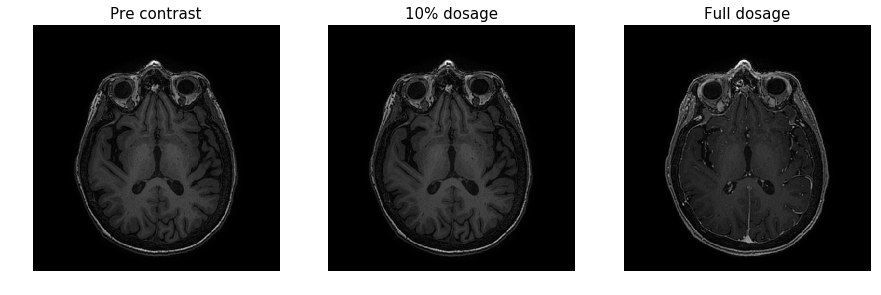

In [4]:
iminfo(ims[:, 0])
iminfo(ims[:, 1])
iminfo(ims[:, 2])

show_gad_comparison(ims[172, 0], ims[172, 1], ims[172, 2])

### Mask images

In [5]:
ims, mask, metadata = mask_images(args, ims, metadata)

masking


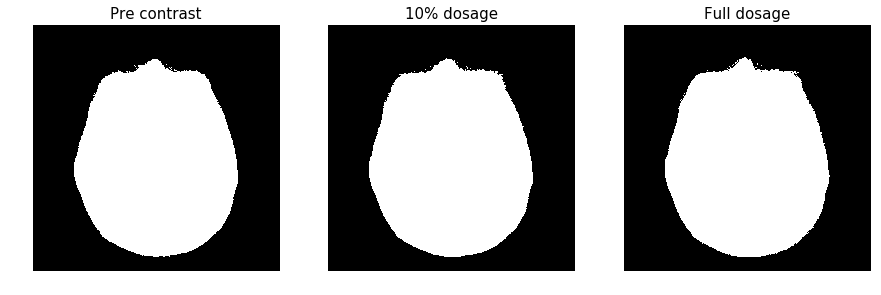

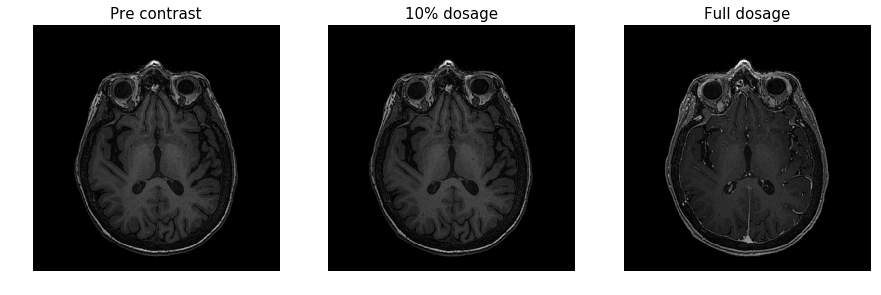

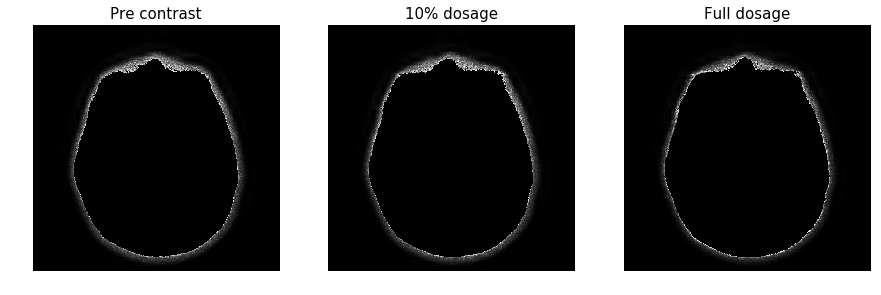

In [6]:
show_gad_comparison(mask[172, 0], mask[172, 1], mask[172, 2])
show_gad_comparison(ims[172, 0], ims[172, 1], ims[172, 2])

pre_diff = diff_img(orig_ims[172, 0], ims[172, 0])
low_diff = diff_img(orig_ims[172, 1], ims[172, 1])
post_diff = diff_img(orig_ims[172, 2], ims[172, 2])

show_gad_comparison(pre_diff, low_diff, post_diff)

### View histograms

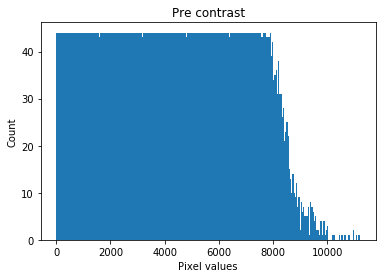

In [7]:
show_hist(ims[:, 0], nbins=255, title='Pre contrast')

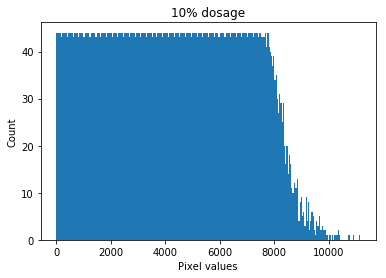

In [8]:
show_hist(ims[:, 1], nbins=255, title='10% dosage')

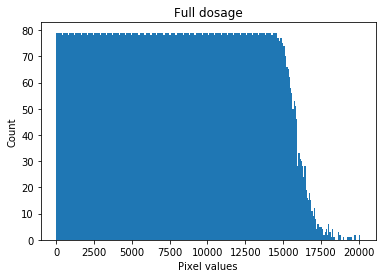

In [9]:
show_hist(ims[:, 2], nbins=255, title='Full dosage')

### Histogram normalization

In [10]:
orig_ims = np.copy(ims)
ims, metadata = hist_norm(args, ims, metadata)

image intensity normalization
scaling done, 6.14 s
image intensity normalization
scaling done, 6.52 s


(512, 512) float32 0.0 9444.0 617.9192
(512, 512) float32 0.0 9460.376 618.2486
(512, 512) float32 0.0 8625.412 586.91455


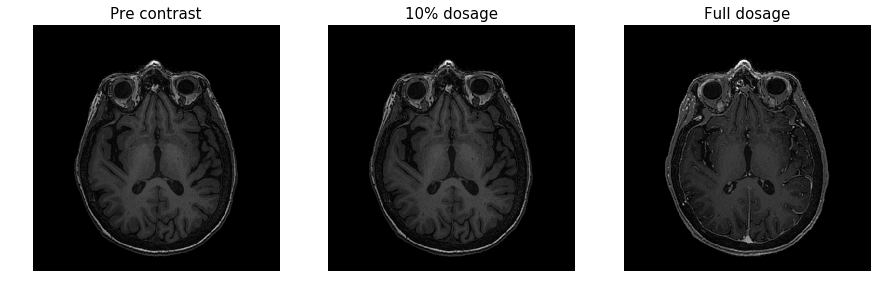

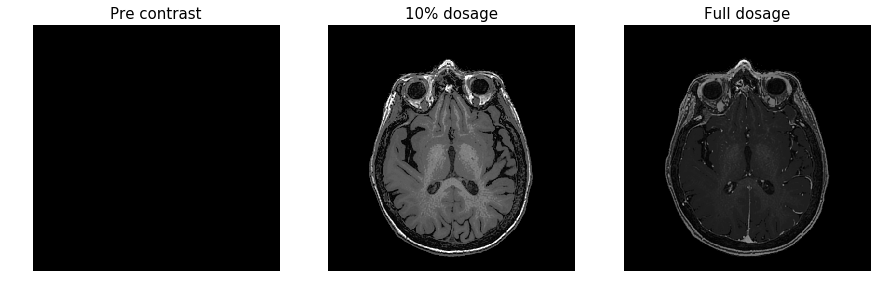

In [11]:
iminfo(ims[172, 0])
iminfo(ims[172, 1])
iminfo(ims[172, 2])

show_gad_comparison(ims[172, 0], ims[172, 1], ims[172, 2])

pre_diff = diff_img(orig_ims[172, 0], ims[172, 0])
low_diff = diff_img(orig_ims[172, 1], ims[172, 1])
post_diff = diff_img(orig_ims[172, 2], ims[172, 2])

show_gad_comparison(pre_diff, low_diff, post_diff)

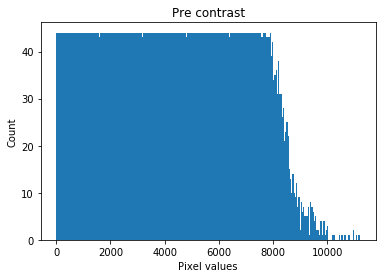

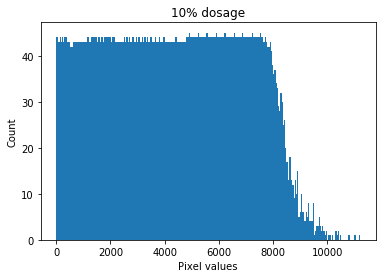

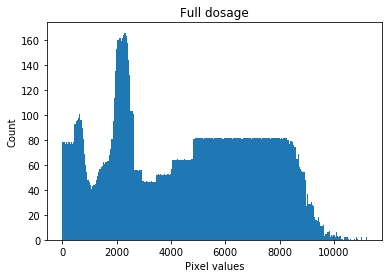

In [12]:
show_hist(ims[:, 0], nbins=255, title='Pre contrast')
show_hist(ims[:, 1], nbins=255, title='10% dosage')
show_hist(ims[:, 2], nbins=255, title='Full dosage')

### Image registration

In [13]:
ims, metadata = register(args, orig_ims, metadata)

image registration
registration done, 35.5 s
low dose transform parameters: ('-0.0021179', '-0.000728278', '-0.0100419', '-0.52389', '0.187115', '-0.0956327')
image registration
registration done, 57.1 s
full dose transform parameters: ('-0.00488793', '-0.00160956', '-0.0104617', '-0.470955', '0.109541', '-0.0895224')


(512, 512) float32 0.0 9444.0 617.9192
(512, 512) float32 0.0 9458.969 610.0999
(512, 512) float32 0.0 15344.1045 1001.6369


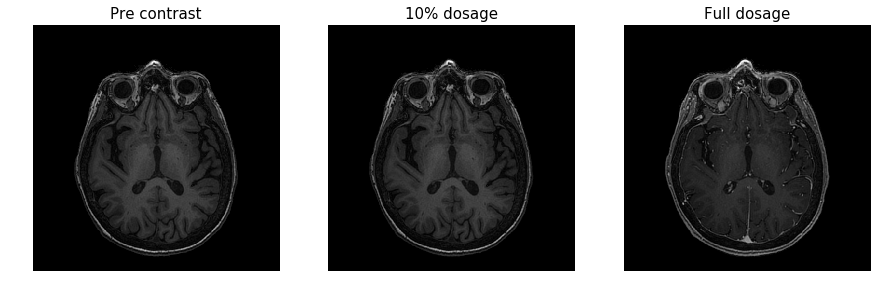

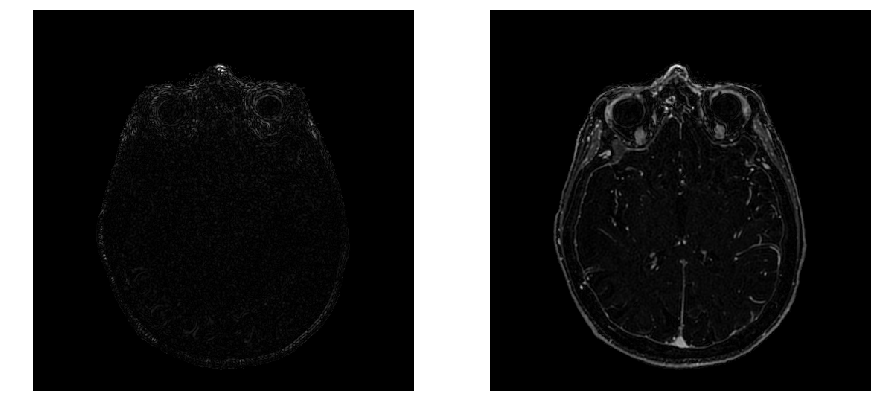

In [14]:
iminfo(ims[172, 0])
iminfo(ims[172, 1])
iminfo(ims[172, 2])

show_gad_comparison(ims[172, 0], ims[172, 1], ims[172, 2])
show_comparison(diff_img(ims[172, 0], ims[172, 1]), diff_img(ims[172, 0], ims[172, 2]))

### Zoom

In [15]:
args.zoom = 512
args.zoom_order = 1

ims_zoom, metadata = zoom_process(args, ims, metadata)

zooming to 512
zoom 0
zoom 0 done: 9.437577247619629 s
zoom 1
zoom 1 done: 8.409598112106323 s
zoom 2
zoom 2 done: 8.410976648330688 s
(368, 3, 512, 512)


(368, 3, 512, 512) float32 0.0 19743.93 550.21466


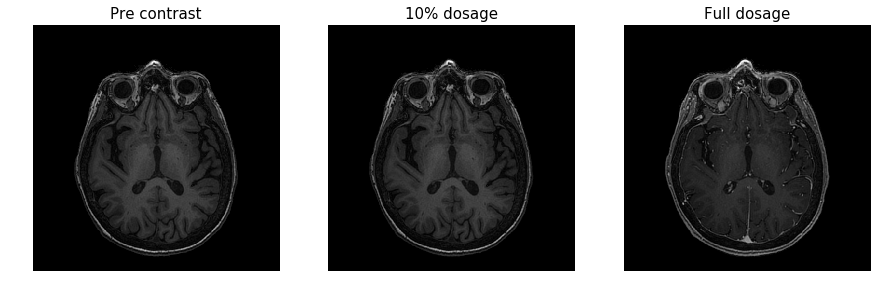

In [16]:
iminfo(ims_zoom)
show_gad_comparison(ims_zoom[172, 0], ims_zoom[172, 1], ims_zoom[172, 2])

### Match scales and global normalization

In [17]:
orig_ims = np.copy(ims)

ims, ims_mod, metadata = prescale_process(args, ims, mask, metadata)
ims, ims_mod, metadata = match_scales(args, ims, ims_mod, metadata)
ims, metadata = global_norm(args, ims, ims_mod, metadata)

intensity before scaling:
mean [1474.1512 1456.5607 2312.3547]
median [1475.     1455.3082 2150.894 ]
max [ 9015.     8907.05  16786.938]
scale low: 1.0066218377137235
scale full: 1.0066218377137235
done scaling data (3.35 s)
intensity after scaling:
mean [1474.1512 1466.2107 2327.6914]
median [1475.     1464.9451 2165.137 ]
max [ 9015.     8966.031 16898.098]
normalizing with function  mean <function mean at 0x7f1643f60510>
intensity before global scaling:
mean [1474.1512 1466.2107 2327.6914]
median [1475.     1464.9451 2165.137 ]
max [ 9015.     8966.031 16898.098]
global scaling: [[1474.1512 1466.2107 2327.6914]]
done (0.31s)
intensity after global scaling:
mean [0.9998293  0.99988025 1.0001142 ]
median [1.0005758  0.9991368  0.93016493]
max [6.115383  6.115104  7.2595954]


(368, 512, 512) float32 0.0 7.606411 0.2982288
(368, 512, 512) float32 0.0 7.455495 0.29911816
(368, 512, 512) float32 0.0 8.538362 0.33530435


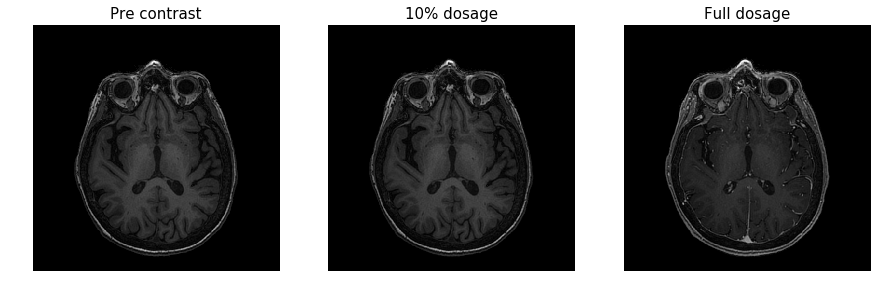

In [18]:
iminfo(ims[:, 0])
iminfo(ims[:, 1])
iminfo(ims[:, 2])

show_gad_comparison(ims[172, 0], ims[172, 1], ims[172, 2])

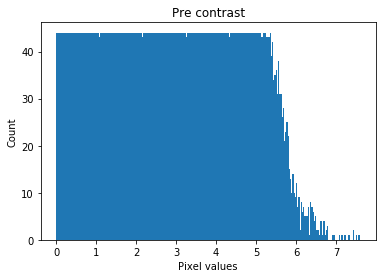

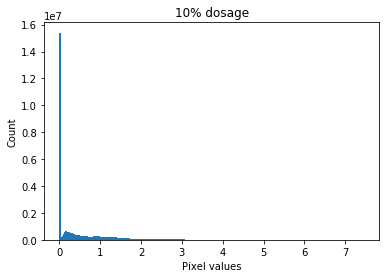

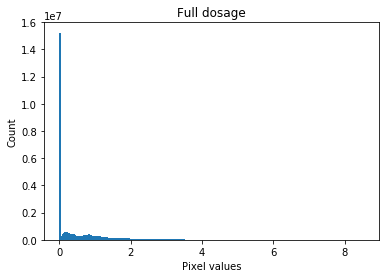

In [19]:
show_hist(ims[:, 0], nbins=255, title='Pre contrast')
show_hist(ims[:, 1], nbins=255, title='10% dosage')
show_hist(ims[:, 2], nbins=255, title='Full dosage')

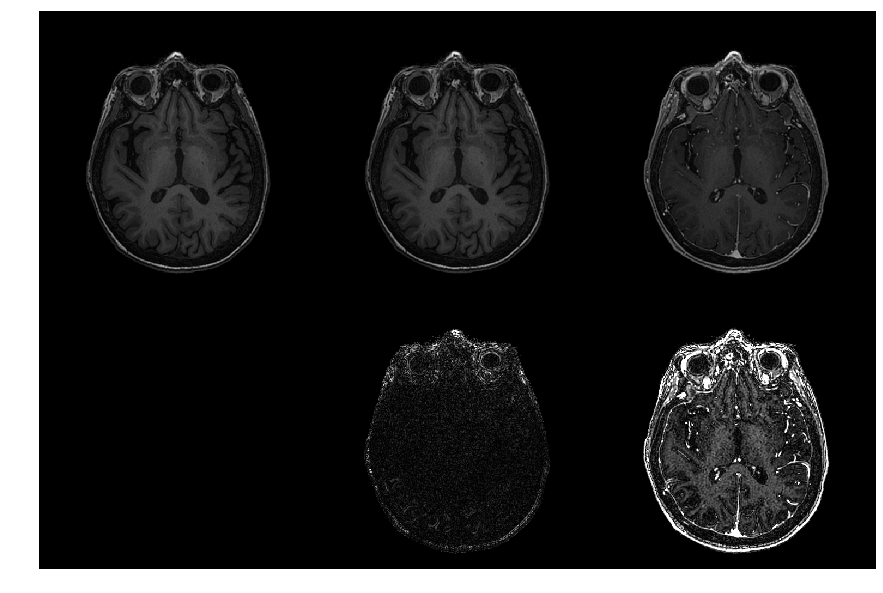

In [20]:
show_final_comparison(ims[172, 0], ims[172, 1], ims[172, 2])